# **Waze Project - Regression Modeling**

In this project, I will build a binomial logistic regression model to predict customer churn rate based on multiple variables. 

**The goal** is to build a binomial logistic regression model and evaluate the model's performance.
<br/>


### Exploratory Data Analysis

In [1]:
# Packages for numerics + dataframes
import pandas as pd
import numpy as np
# Packages for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Packages for Logistic Regression & Confusion Matrix
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('waze_cleaned')

In [3]:
print(df.shape)
print('')
df.info()

(14999, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      14999 non-null  int64  
 1   ID                              14999 non-null  int64  
 2   label                           14299 non-null  object 
 3   sessions                        14999 non-null  int64  
 4   drives                          14999 non-null  int64  
 5   total_sessions                  14999 non-null  float64
 6   n_days_after_onboarding         14999 non-null  int64  
 7   total_navigations_fav1          14999 non-null  int64  
 8   total_navigations_fav2          14999 non-null  int64  
 9   driven_km_drives                14999 non-null  float64
 10  duration_minutes_drives         14999 non-null  float64
 11  activity_days                   14999 non-null  int64  
 12  driving_days       

In [4]:
df = df.drop(['ID','Unnamed: 0'], axis=1)

- The ID column is removed since we don't need this information for our analysis.

#### **`professional_driver`**

Create a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

In [5]:
# Create `professional_driver` column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1,0)
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver
0,retained,243,201,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1
1,retained,133,107,326.896596,1225,19,64,8889.794236,3160.472914,13,11,iPhone,1246.901868,0.406856,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1


In [6]:
# 1. Check count of professionals and non-professionals
print(df['professional_driver'].value_counts())

# 2. Check in-class churn rate
df.groupby('professional_driver')['label'].value_counts(normalize=True)

0    12405
1     2594
Name: professional_driver, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: label, dtype: float64

The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   label                           14299 non-null  object 
 1   sessions                        14999 non-null  int64  
 2   drives                          14999 non-null  int64  
 3   total_sessions                  14999 non-null  float64
 4   n_days_after_onboarding         14999 non-null  int64  
 5   total_navigations_fav1          14999 non-null  int64  
 6   total_navigations_fav2          14999 non-null  int64  
 7   driven_km_drives                14999 non-null  float64
 8   duration_minutes_drives         14999 non-null  float64
 9   activity_days                   14999 non-null  int64  
 10  driving_days                    14999 non-null  int64  
 11  device                          14999 non-null  object 
 12  km_per_driving_day              

In [8]:
# Drop rows with missing data in `label` column
df = df.dropna(subset = ['label'], axis=0)

In [9]:
# Impute outliers
columns = ['sessions','drives','total_sessions','total_navigations_fav1','total_navigations_fav2','driven_km_drives','duration_minutes_drives']
def outlier_imputer(column, percentile):
    threshold = df[column].quantile(percentile)
    df.loc[df[column] > threshold, column] = threshold
for i in columns:
    outlier_imputer(i, 0.95)

In [10]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.663233,1751.822505,114.562767,27.187216,3944.110515,1792.911210,15.544653,12.182530,581.942399,0.449837,0.173998
std,67.243178,55.127927,118.596924,1008.663834,124.378550,36.715302,2217.358063,1224.329759,9.016088,7.833835,1038.254509,0.286863,0.379121
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.196890,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.424310,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.687251,0.000000
max,243.000000,200.000000,454.363204,3500.000000,422.000000,124.000000,8889.794236,4668.180092,31.000000,30.000000,15420.234110,1.530637,1.000000


#### **Encode categorical variables**

In [11]:
# Initialize the OneHotEncoder

df['label2'] = np.where(df['label']=='churned',1,0)
# Display the last few rows of the DataFrame with 'label' and 'label2'
df.tail()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,label2
14994,retained,60,55,207.875622,140,317,0,2890.496901,2186.155708,25,17,iPhone,170.029229,0.288634,0,0
14995,retained,42,35,187.670313,2505,15,10,4062.575194,1208.583193,25,20,Android,203.128760,0.223797,0,0
14996,retained,243,200,422.017241,1873,17,0,3097.825028,1031.278706,18,17,iPhone,182.225002,0.646893,1,0
14997,churned,149,120,180.524184,3150,45,0,4051.758549,254.187763,6,6,iPhone,675.293092,0.825374,0,1
14998,retained,73,58,353.419797,3383,13,51,6030.498773,3042.436423,14,13,iPhone,463.884521,0.206553,0,0


The following are the assumptions for logistic regression:

* Independent observations (This refers to how the data was collected.)

* No extreme outliers

* Little to no multicollinearity among X predictors

* Linear relationship between X and the **logit** of y

For the first assumption, you can assume that observations are independent for this project.

The second assumption has already been addressed.

The last assumption will be verified after modeling.

#### **Collinearity**

In [12]:
# Generate a correlation matrix
df.corr(method='pearson')

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,professional_driver,label2
sessions,1.000000,0.996942,0.597299,0.007101,0.001858,0.008536,0.002995,-0.004545,0.025113,0.020294,-0.011569,0.614136,0.443654,0.034911
drives,0.996942,1.000000,0.595396,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.614282,0.444425,0.035865
total_sessions,0.597299,0.595396,1.000000,0.006615,0.000194,0.010363,0.001015,-0.000345,0.015757,0.012957,-0.016162,-0.113455,0.254532,0.024568
n_days_after_onboarding,0.007101,0.006940,0.006615,1.000000,-0.002450,-0.004968,-0.004655,-0.010167,-0.009418,-0.007321,0.011764,-0.000874,0.003770,-0.129263
total_navigations_fav1,0.001858,0.001058,0.000194,-0.002450,1.000000,0.002866,-0.007365,0.005646,0.010902,0.010419,-0.000197,0.015180,-0.000224,0.052322
total_navigations_fav2,0.008536,0.009505,0.010363,-0.004968,0.002866,1.000000,0.003567,-0.003009,-0.004425,0.002000,0.006751,0.000603,0.007126,0.015032
driven_km_drives,0.002995,0.003445,0.001015,-0.004655,-0.007365,0.003567,1.000000,0.690547,-0.007445,-0.009550,0.344765,-0.002088,-0.000901,0.019771
duration_minutes_drives,-0.004545,-0.003889,-0.000345,-0.010167,0.005646,-0.003009,0.690547,1.000000,-0.007895,-0.009425,0.239627,-0.007884,-0.012128,0.040407
activity_days,0.025113,0.024357,0.015757,-0.009418,0.010902,-0.004425,-0.007445,-0.007895,1.000000,0.947687,-0.397433,0.017840,0.453825,-0.303851
driving_days,0.020294,0.019608,0.012957,-0.007321,0.010419,0.002000,-0.009550,-0.009425,0.947687,1.000000,-0.407917,0.013550,0.469776,-0.294259


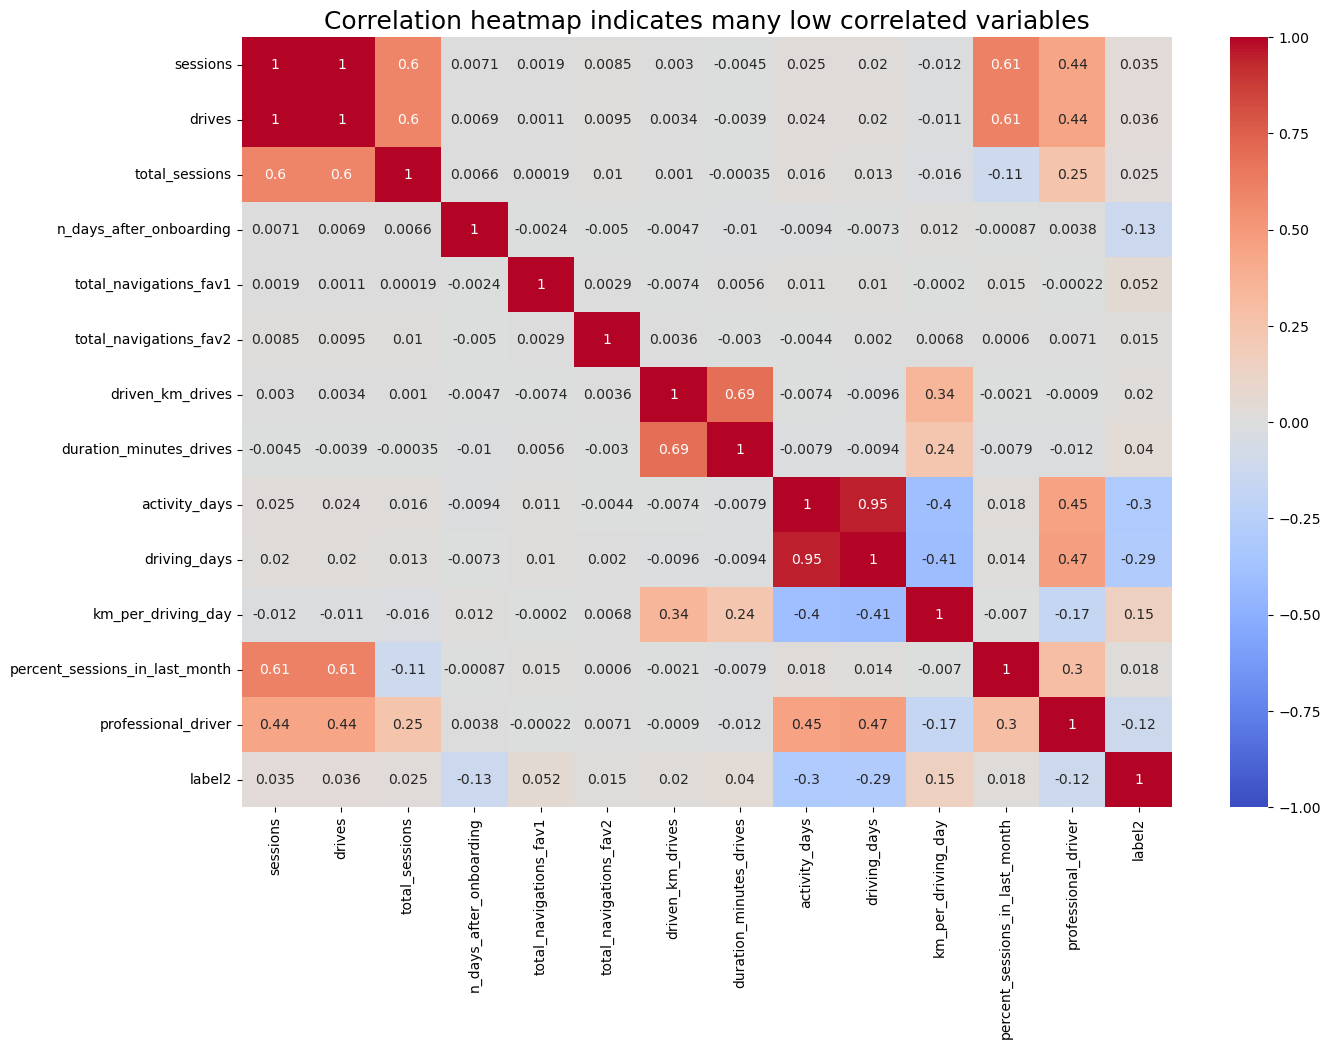

In [13]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1,annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=18)
plt.show()

Following variables are multicollinear with each other.

- ``driving_days`` vs ``activity_days``
- ``sessions`` vs ``drives``

In [14]:
# Create new `device2` variable
df['device2'] = OneHotEncoder(drop='first').fit_transform(df[['device']]).toarray()
df[['device','device2']].tail()

,device,device2
14994,iPhone,1.0
14995,Android,0.0
14996,iPhone,1.0
14997,iPhone,1.0
14998,iPhone,1.0


### **Task 3d. Model building**

In [15]:
# Isolate predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

In [16]:
# Isolate target variable
y = df['label2']

In [17]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [18]:
# Use .head()
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,percent_sessions_in_last_month,professional_driver,device2
152,108,186.192746,3116,243,124,8889.794236,4668.180092,24,612.305861,0.698201,1,1.0
11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0.573462,0,1.0
10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0.492644,0,0.0
669,108,454.363204,2320,11,4,6566.424830,4558.459870,18,410.401552,0.272322,1,1.0
8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0.111762,0,1.0


In [19]:
model = LogisticRegression(penalty = 'none', max_iter=400)
model.fit(X_train,y_train)

LogisticRegression(max_iter=400, penalty='none')

Call the `.coef_` attribute on the model to get the coefficients of each variable.  The coefficients are in order of how the variables are listed in the dataset.  Remember that the coefficients represent the change in the **log odds** of the target variable for **every one unit increase in X**.

If you want, create a series whose index is the column names and whose values are the coefficients in `model.coef_`.

In [20]:
pd.Series(model.coef_[0], index=X.columns)

drives                            0.001915
total_sessions                    0.000328
n_days_after_onboarding          -0.000406
total_navigations_fav1            0.001232
total_navigations_fav2            0.000931
driven_km_drives                 -0.000015
duration_minutes_drives           0.000109
activity_days                    -0.106026
km_per_driving_day                0.000018
percent_sessions_in_last_month   -0.000750
professional_driver              -0.001528
device2                          -0.001040
dtype: float64

In [21]:
model.intercept_

array([-0.00170698])

#### **Check final assumption**
Call the model's `predict_proba()` method to generate the probability of response for each sample in the training data. (The training data is the argument to the method.) Assign the result to a variable called `training_probabilities`. This results in a 2-D array where each row represents a user in `X_train`. The first column is the probability of the user not churning, and the second column is the probability of the user churning.

In [22]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93963029, 0.06036971],
       [0.61974878, 0.38025122],
       [0.76458303, 0.23541697],
       ...,
       [0.91909349, 0.08090651],
       [0.85090481, 0.14909519],
       [0.93515386, 0.06484614]])

In [23]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

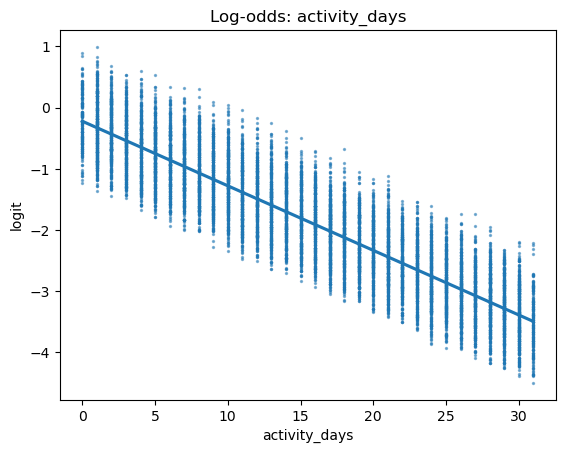

In [24]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

In [25]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

In [26]:
# Score the model (accuracy) on the test data
model.score(X_test, y_test)

0.8237762237762237

In [27]:
cm = metrics.confusion_matrix(y_test, y_preds, labels = model.classes_)

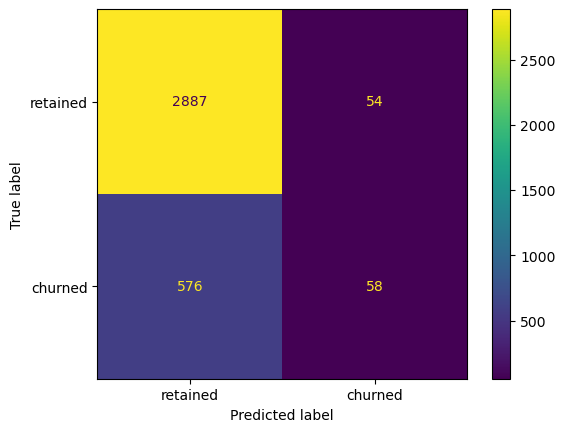

In [28]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained','churned'])
disp.plot()

In [29]:
# Calculate precision manually
metrics.precision_score(y_test, y_preds)

0.5178571428571429

In [30]:
# Calculate recall manually
metrics.recall_score(y_test,y_preds)

0.0914826498422713

In [31]:
# Create a classification report
target_labels = ['retained', 'churned']
print(metrics.classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.52      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



**Note:** The model has decent precision but very low recall, which means that it makes a lot of false negative predictions and fails to capture users who will churn.

In [32]:
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: np.abs(x[1]), reverse=True)
feature_importance

[('activity_days', -0.10602617760792689),
 ('drives', 0.0019152478107402886),
 ('professional_driver', -0.0015281603135072765),
 ('total_navigations_fav1', 0.0012316080948239347),
 ('device2', -0.0010404247446017718),
 ('total_navigations_fav2', 0.0009311105238662267),
 ('percent_sessions_in_last_month', -0.0007497830104972934),
 ('n_days_after_onboarding', -0.00040647744072998336),
 ('total_sessions', 0.000327868684016819),
 ('duration_minutes_drives', 0.0001091155788076167),
 ('km_per_driving_day', 1.8246661916962113e-05),
 ('driven_km_drives', -1.4866891558891179e-05)]

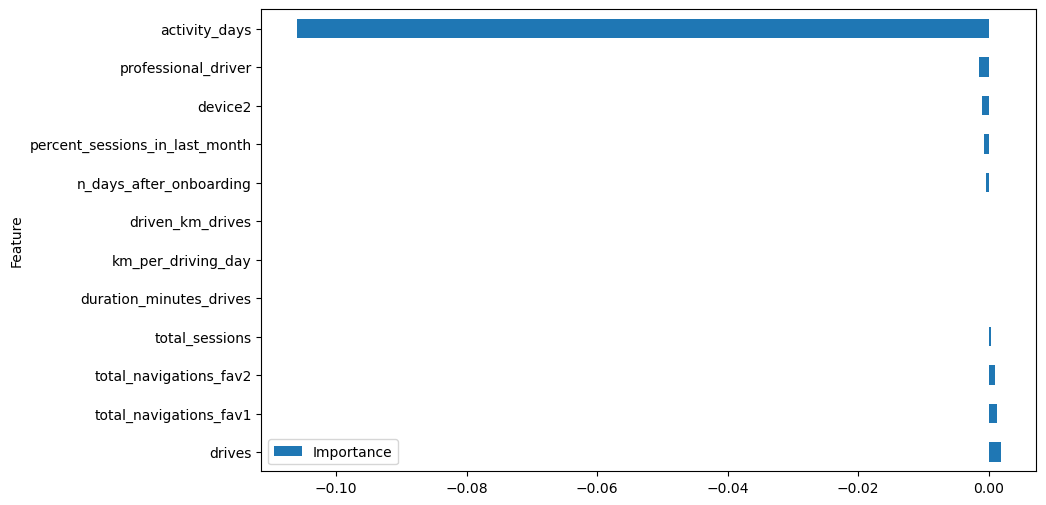

In [33]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

plt.show()

## Conclusion

- `activity_days` was the most important feature of the logistic regression model.


- `n_days_after_onboarding`, `activity_days`, `km_per_driving_days`, and `professional_driver` were expected to be strong predictors based on the correlation matrix. In the model, `km_per_driving_day` was the second least important feature and `n_days_after_onboarding` was the fifth least important feature.

- A variable  may not be significant in a logistic regression model due to multicollinearity, non-linearity, interaction effects, small effect size, missing information, model complexity, outliers, or incorrect assumptions about the data. Thorough analysis and consideration of alternative models are essential for accurate variable importance assessment.

- This model has very poor recall score and can't effectively predict churned customers. Therefore, it is not recommended to use for making critical business decision although it can be used as a guide for further exploration.

- New features could be engineered to build a better predictive model. Having drive-level information, including drive times and locations, would be useful. More detailed data on user interactions, like reporting road hazards, could provide valuable insights. Additionally, knowing the monthly count of unique starting and ending locations per driver would be beneficial.

In [34]:
df.to_csv('waze_ml_ready')